In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

In [ ]:
yf.download('AAPL', period='max', interval='1m')

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-07-09 09:30:00-04:00,228.184998,228.259995,227.190094,227.214005,227.214005,1776933
2024-07-09 09:31:00-04:00,227.229996,227.360001,226.710007,226.764999,226.764999,289659
2024-07-09 09:32:00-04:00,226.756607,226.943497,226.372101,226.661407,226.661407,319010
2024-07-09 09:33:00-04:00,226.639999,226.978806,226.429993,226.728897,226.728897,277397
2024-07-09 09:34:00-04:00,226.710007,227.190002,226.710007,227.080002,227.080002,279249
...,...,...,...,...,...,...
2024-07-15 15:55:00-04:00,234.250000,234.449997,234.149994,234.190002,234.190002,243367
2024-07-15 15:56:00-04:00,234.199997,234.358902,234.169998,234.300003,234.300003,188377
2024-07-15 15:57:00-04:00,234.289993,234.315002,234.130005,234.225006,234.225006,202041


In [ ]:
# Função para baixar dados históricos de uma ação
def download_data(ticker, period='max', interval='1m'):
    stock_data = yf.download(ticker, period=period, interval=interval)
    return stock_data

In [ ]:
# Function to prepare the data
def prepare_data(data):
    # Selecionar colunas relevantes e fazer uma cópia para evitar advertências
    data_selected = data[['Open', 'Close', 'Volume']].copy()

    # Calcular a média entre 'Open' e 'Close' usando .loc para evitar o SettingWithCopyWarning
    data_selected.loc[:, 'Average'] = data_selected[['Open', 'Close']].mean(axis=1)

    # Selecionar as colunas finais
    data_final = data_selected[['Volume', 'Average']]

    return data_final

In [ ]:
# Função para criar as matrizes e os labels
def create_matrices(data_final, n):
    num_rows = data_final.shape[0]
    num_matrices = num_rows // n  # Número de matrizes completas que podemos formar

    matrices = []
    matrices_y = []

    for i in range(num_matrices):
        start_idx = i * n
        end_idx = start_idx + n
        matrix = data_final.iloc[start_idx:end_idx].copy()

        # Calcular a soma da coluna de volume
        volume_sum = matrix['Volume'].sum()

        # Tornar a coluna do volume relativa
        matrix['Volume'] = matrix['Volume'] / volume_sum

        # Converter para valores numpy e adicionar à lista de matrizes
        matrices.append(matrix.values)

        # Criar labels
        if i > 0:  # Ignorar a primeira matriz para alinhamento correto
            first_value = matrices[i][0, 1]
            last_value = matrices[i][n-1, 1]
            delta = last_value - first_value
            delta_bi = 1 if delta > 0 else 0
            matrices_y.append(delta_bi)

    # Ordenar as linhas de cada matriz por ordem decrescente da coluna Average (segunda coluna)
    matrices_x = []
    for matrix in matrices:
        sorted_indices = np.argsort(matrix[:, 1])[::-1]
        sorted_matrix = matrix[sorted_indices]
        matrices_x.append(sorted_matrix)

    # Remover a última matriz de matrices_x para alinhamento com matrices_y
    if matrices_x:
        matrices_x.pop()

    # Converter listas para arrays numpy
    matrices_x = np.array(matrices_x)
    matrices_y = np.array(matrices_y)

    return matrices_x, matrices_y

In [ ]:
# Função para construir a rede neural
def build_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Função principal
def main():
    # Definir o ticker da ação
    ticker = 'AAPL'

    # Baixar dados históricos
    data = download_data(ticker, period='max', interval='1m')

    # Preparar os dados
    data_final = prepare_data(data)

    # Criar as matrizes e os labels
    matrices_x, matrices_y = create_matrices(data_final)

    # Imprimir o tamanho do dataset
    print(f"Tamanho do dataset: {matrices_x.shape[0]}")

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(matrices_x, matrices_y, test_size=0.2, random_state=42)

    # Construir a rede neural
    model = build_model(input_shape=(5, 2))

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=10, validation_split=0.2)

    # Avaliar o modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Acurácia no conjunto de teste: {accuracy:.4f}')

    # Fazer previsões
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)

    # Verificar o tamanho do conjunto de teste
    num_to_display = min(10, len(y_test))

    # Exibir as primeiras previsões e seus valores reais correspondentes
    for i in range(num_to_display):
        print(f'Predição: {predictions[i]}, Real: {y_test[i]}')

if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed
<ipython-input-3-f66c72133631>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Average'] = data_selected[['Open', 'Close']].mean(axis=1)


Tamanho do dataset: 388
Epoch 1/10
8/8 [==============================] - 1s 36ms/step - loss: 3.5060 - accuracy: 0.4960 - val_loss: 0.7548 - val_accuracy: 0.5806
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 1.1211 - accuracy: 0.5121 - val_loss: 1.2635 - val_accuracy: 0.4194
Epoch 3/10
8/8 [==============================] - 0s 7ms/step - loss: 1.0234 - accuracy: 0.5121 - val_loss: 1.0652 - val_accuracy: 0.4194
Epoch 4/10
8/8 [==============================] - 0s 8ms/step - loss: 0.9430 - accuracy: 0.4597 - val_loss: 0.6878 - val_accuracy: 0.5806
Epoch 5/10
8/8 [==============================] - 0s 6ms/step - loss: 1.2070 - accuracy: 0.5121 - val_loss: 0.7115 - val_accuracy: 0.5806
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.8701 - accuracy: 0.5202 - val_loss: 0.8257 - val_accuracy: 0.5806
Epoch 7/10
8/8 [==============================] - 0s 10ms/step - loss: 0.7989 - accuracy: 0.5121 - val_loss: 0.6926 - val_accuracy: 0.5806
Epoch 8/

In [ ]:
# Definir o ticker da ação
ticker = 'AAPL'

# Baixar dados históricos
data = download_data(ticker, period='max', interval='1m')

# Preparar os dados
data_final = prepare_data(data)

# Criar as matrizes e os labels
all_matrices_x, all_matrices_y = create_matrices(data_final, 12)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
import numpy as np

# Supondo que all_matrices_x e all_matrices_y já estejam definidos

# Total de amostras
n_samples = all_matrices_x.shape[0]

# Índices para divisão
train_size = int(0.6 * n_samples)  # 60% para treino
val_size = int(0.2 * n_samples)    # 20% para validação
test_size = n_samples - train_size - val_size  # 20% para teste

# Dividir os dados sequencialmente
X_train = all_matrices_x[:train_size]
y_train = all_matrices_y[:train_size]

X_val = all_matrices_x[train_size:train_size + val_size]
y_val = all_matrices_y[train_size:train_size + val_size]

X_test = all_matrices_x[train_size + val_size:]
y_test = all_matrices_y[train_size + val_size:]

In [ ]:
# Verificar as formas dos conjuntos de dados
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (96, 12, 2)
Shape of y_train: (96,)
Shape of X_val: (32, 12, 2)
Shape of y_val: (32,)
Shape of X_test: (33, 12, 2)
Shape of y_test: (33,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Função para construir a rede neural com LSTM
def build_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(64, return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Construir a rede neural
model = build_model(input_shape=(12, 2))

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/5
6/6 [==============================] - 6s 231ms/step - loss: 0.6935 - accuracy: 0.4896 - val_loss: 0.6914 - val_accuracy: 0.5312
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.6963 - accuracy: 0.5104 - val_loss: 0.6914 - val_accuracy: 0.5312
Epoch 3/5
6/6 [==============================] - 0s 15ms/step - loss: 0.6963 - accuracy: 0.5104 - val_loss: 0.6930 - val_accuracy: 0.5312
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.6939 - accuracy: 0.5104 - val_loss: 0.6928 - val_accuracy: 0.5312
Epoch 5/5
6/6 [==============================] - 0s 19ms/step - loss: 0.6943 - accuracy: 0.5104 - val_loss: 0.6920 - val_accuracy: 0.5312


In [ ]:
# Avaliar o modelo nos dados de teste
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 1s 9ms/step - loss: 0.6912 - accuracy: 0.5455
Test Accuracy: 0.5454545617103577


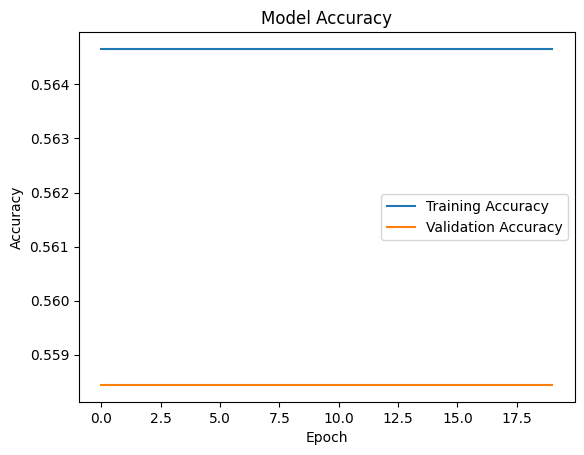

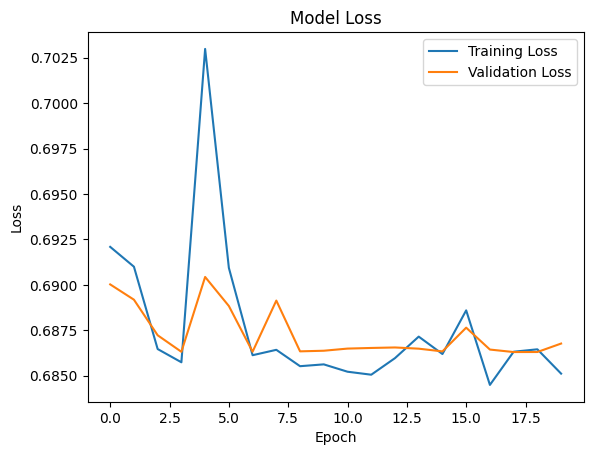

In [ ]:
# Plotar a precisão e a perda ao longo das épocas
import matplotlib.pyplot as plt

# Precisão
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Perda
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()